# **SAVED MODEL**

## Import Library

In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
import os
import json
from pathlib import Path
from google.colab import files
import shutil
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## Upload Model .Keras

In [2]:
# Class information
CLASS_NAMES = ['lung_aca', 'lung_n', 'lung_scc']
CLASS_LABELS = {
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Lung Benign Tissue',
    'lung_scc': 'Lung Squamous Cell Carcinoma'
}

# Upload Model File

uploaded = files.upload()

if uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    file_size = len(uploaded[uploaded_filename]) / (1024 * 1024)
    print(f"\nFile berhasil di-upload: {uploaded_filename}")
    print(f"Ukuran: {file_size:.2f} MB")
else:
    print("\nTidak ada file yang di-upload!")
    raise Exception("Upload cancelled")

Saving best_vgg16.keras to best_vgg16.keras

File berhasil di-upload: best_vgg16.keras
Ukuran: 72.77 MB


In [3]:
# Load Model

try:
    model_path = uploaded_filename
    model = tf.keras.models.load_model(model_path)

    print(f"\nModel berhasil di-load dari: {model_path}")
    print(f"\nModel Info:")
    print(f"Name: {model.name}")
    print(f"Total layers: {len(model.layers)}")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")

    # Count parameters
    total_params = model.count_params()
    print(f"Total parameters: {total_params:,}")

except Exception as e:
    print(f"\nError saat loading model: {e}")
    raise


Model berhasil di-load dari: best_vgg16.keras

Model Info:
Name: VGG16_TransferLearning_Optimized
Total layers: 11
Input shape: (None, 224, 224, 3)
Output shape: (None, 3)
Total parameters: 16,160,323


## Save ke SavedModel Format

In [4]:
saved_model_dir = "saved_model"

try:

    model.export(saved_model_dir)

    print(f"SavedModel berhasil disimpan!")

    saved_files = list(Path(saved_model_dir).rglob("*"))

except Exception as e:
    print(f"\nError saat save SavedModel: {e}")
    raise

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139798844408080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844412112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844411728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844410384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844412688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844410000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844413072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844411536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844413840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844409040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844414416: T

## Convert dan Save ke TFLite Format

In [5]:
tflite_dir = "tflite"
os.makedirs(tflite_dir, exist_ok=True)

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    tflite_model = converter.convert()

    print("Conversion selesai!")

    # Save TFLite model
    tflite_path = Path(tflite_dir) / "model.tflite"
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    file_size = os.path.getsize(tflite_path) / (1024 * 1024)
    print(f"\nTFLite model berhasil disimpan!")
    print(f"Path: {tflite_path}")
    print(f"Size: {file_size:.2f} MB")

    # Verify TFLite model
    print("\nVerifying TFLite model...")
    interpreter = tf.lite.Interpreter(model_path=str(tflite_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("TFLite model valid")
    print(f"Input shape: {input_details[0]['shape']}")
    print(f"Output shape: {output_details[0]['shape']}")

except Exception as e:
    print(f"\nError saat converting ke TFLite: {e}")
    raise

Saved artifact at '/tmp/tmpft_km651'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139798844408080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844412112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844411728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844410384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844412688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844410000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844413072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844411536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844413840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798844409040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397988444144

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [6]:
# Buat label.txt untuk TFLite

try:
    label_path = Path(tflite_dir) / "label.txt"

    with open(label_path, 'w', encoding='utf-8') as f:
        for class_name in CLASS_NAMES:
            f.write(f"{CLASS_LABELS[class_name]}\n")

    print(f"\nLabel file berhasil dibuat: {label_path}")
    print(f"\nIsi label.txt:")
    with open(label_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            print(f"  {i}: {line.strip()}")

except Exception as e:
    print(f"\nError saat membuat label.txt: {e}")


Label file berhasil dibuat: tflite/label.txt

Isi label.txt:
  0: Lung Adenocarcinoma
  1: Lung Benign Tissue
  2: Lung Squamous Cell Carcinoma


## Convert dan Save ke TensorFlow.js Format

In [7]:
tfjs_dir = "tfjs_model"

try:

    tfjs.converters.save_keras_model(model, tfjs_dir)

    print(f"\nConversion berhasil!")

    # List files
    tfjs_files = list(Path(tfjs_dir).glob("*"))
    print(f"\nFiles yang dihasilkan ({len(tfjs_files)} files):")

    total_size = 0
    for file in sorted(tfjs_files):
        size = os.path.getsize(file) / (1024 * 1024)
        total_size += size
        print(f"   - {file.name} ({size:.2f} MB)")

    print(f"\nTotal size: {total_size:.2f} MB")

    # Verify model.json
    model_json_path = Path(tfjs_dir) / "model.json"
    if model_json_path.exists():
        print(f"\nmodel.json ditemukan")
    else:
        print(f"\nWarning: model.json tidak ditemukan!")

except Exception as e:
    print(f"\nError saat conversion ke TensorFlow.js: {e}")
    raise

failed to lookup keras version from the file,
    this is likely a weight only file

Conversion berhasil!

Files yang dihasilkan (17 files):
   - group1-shard10of16.bin (4.00 MB)
   - group1-shard11of16.bin (4.00 MB)
   - group1-shard12of16.bin (4.00 MB)
   - group1-shard13of16.bin (4.00 MB)
   - group1-shard14of16.bin (4.00 MB)
   - group1-shard15of16.bin (4.00 MB)
   - group1-shard16of16.bin (1.65 MB)
   - group1-shard1of16.bin (4.00 MB)
   - group1-shard2of16.bin (4.00 MB)
   - group1-shard3of16.bin (4.00 MB)
   - group1-shard4of16.bin (4.00 MB)
   - group1-shard5of16.bin (4.00 MB)
   - group1-shard6of16.bin (4.00 MB)
   - group1-shard7of16.bin (4.00 MB)
   - group1-shard8of16.bin (4.00 MB)
   - group1-shard9of16.bin (4.00 MB)
   - model.json (0.02 MB)

Total size: 61.67 MB

model.json ditemukan


## Membuat Zip Archive

In [8]:
try:

    output_base = 'model_output'
    os.makedirs(output_base, exist_ok=True)

    # Copy saved_model
    if os.path.exists(saved_model_dir):
        dest = os.path.join(output_base, 'saved_model')
        if os.path.exists(dest):
            shutil.rmtree(dest)
        shutil.copytree(saved_model_dir, dest)

    # Copy tflite
    if os.path.exists(tflite_dir):
        dest = os.path.join(output_base, 'tflite')
        if os.path.exists(dest):
            shutil.rmtree(dest)
        shutil.copytree(tflite_dir, dest)

    # Copy tfjs_model
    if os.path.exists(tfjs_dir):
        dest = os.path.join(output_base, 'tfjs_model')
        if os.path.exists(dest):
            shutil.rmtree(dest)
        shutil.copytree(tfjs_dir, dest)

    # Create zip archive
    shutil.make_archive('model_output', 'zip', output_base)

    zip_size = os.path.getsize('model_output.zip') / (1024 * 1024)

    print("\nArchive berhasil dibuat!")

except Exception as e:
    print(f"\nError creating archive: {e}")
    raise


Archive berhasil dibuat!


# **INFERENCE**

## Upload Gambar

In [9]:
uploaded_images = files.upload()

if not uploaded_images:
    print("\nTidak ada gambar yang di-upload!")
    raise Exception("Upload cancelled")

print(f"\nBerhasil upload {len(uploaded_images)} gambar:")
for filename in uploaded_images.keys():
    file_size = len(uploaded_images[filename]) / 1024
    print(f"   - {filename} ({file_size:.2f} KB)")

Saving 0000.jpg to 0000.jpg
Saving 0012.jpg to 0012.jpg
Saving 0014.jpg to 0014.jpg

Berhasil upload 3 gambar:
   - 0000.jpg (102.98 KB)
   - 0012.jpg (129.06 KB)
   - 0014.jpg (82.80 KB)


## Load Model (SavedModel)

In [10]:
if 'model' not in locals():
    print("\nLoading model dari saved_model...")
    try:
        model = tf.keras.models.load_model("saved_model")
        print("Model berhasil di-load!")
    except:
        print("Model tidak ditemukan")
        raise
else:
    print("\nModel sudah tersedia di memory")

print(f"\nModel Info:")
print(f"Name: {model.name}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

# Class information
CLASS_NAMES = ['lung_aca', 'lung_n', 'lung_scc']
CLASS_LABELS = {
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Lung Benign Tissue',
    'lung_scc': 'Lung Squamous Cell Carcinoma'
}

print(f"\nClasses:")
for i, (name, label) in enumerate(CLASS_LABELS.items()):
    print(f"  {i}: {label}")


Model sudah tersedia di memory

Model Info:
Name: VGG16_TransferLearning_Optimized
Input shape: (None, 224, 224, 3)
Output shape: (None, 3)

Classes:
  0: Lung Adenocarcinoma
  1: Lung Benign Tissue
  2: Lung Squamous Cell Carcinoma


## Preprocessing & Prediction Function

In [11]:
def preprocess_image(img_path, target_size=(224, 224)):

    # Load image
    img = image.load_img(img_path, target_size=target_size)

    # Convert to array
    img_array = image.img_to_array(img)

    # Rescale
    img_array = img_array / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

def predict_image(model, img_path, class_names, class_labels):

    # Preprocess
    img_display, img_array = preprocess_image(img_path)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]

    # Get labels
    predicted_class_name = class_names[predicted_class_idx]
    predicted_label = class_labels[predicted_class_name]

    return {
        'image': img_display,
        'predictions': predictions[0],
        'predicted_class_idx': predicted_class_idx,
        'predicted_class_name': predicted_class_name,
        'predicted_label': predicted_label,
        'confidence': confidence
    }

In [12]:
results = []

for idx, filename in enumerate(uploaded_images.keys()):
    print(f"\n[{idx+1}/{len(uploaded_images)}] Processing: {filename}")

    # Predict
    result = predict_image(model, filename, CLASS_NAMES, CLASS_LABELS)
    result['filename'] = filename
    results.append(result)

    # Print result
    print(f"Predicted: {result['predicted_label']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"All probabilities:")
    for i, (class_name, prob) in enumerate(zip(CLASS_NAMES, result['predictions'])):
        label = CLASS_LABELS[class_name]
        print(f"      {i}. {label}: {prob:.2%}")

print(f"\nInference selesai")


[1/3] Processing: 0000.jpg
Predicted: Lung Adenocarcinoma
Confidence: 100.00%
All probabilities:
      0. Lung Adenocarcinoma: 100.00%
      1. Lung Benign Tissue: 0.00%
      2. Lung Squamous Cell Carcinoma: 0.00%

[2/3] Processing: 0012.jpg
Predicted: Lung Squamous Cell Carcinoma
Confidence: 100.00%
All probabilities:
      0. Lung Adenocarcinoma: 0.00%
      1. Lung Benign Tissue: 0.00%
      2. Lung Squamous Cell Carcinoma: 100.00%

[3/3] Processing: 0014.jpg
Predicted: Lung Benign Tissue
Confidence: 100.00%
All probabilities:
      0. Lung Adenocarcinoma: 0.00%
      1. Lung Benign Tissue: 100.00%
      2. Lung Squamous Cell Carcinoma: 0.00%

Inference selesai


## Visualisasi Prediksi

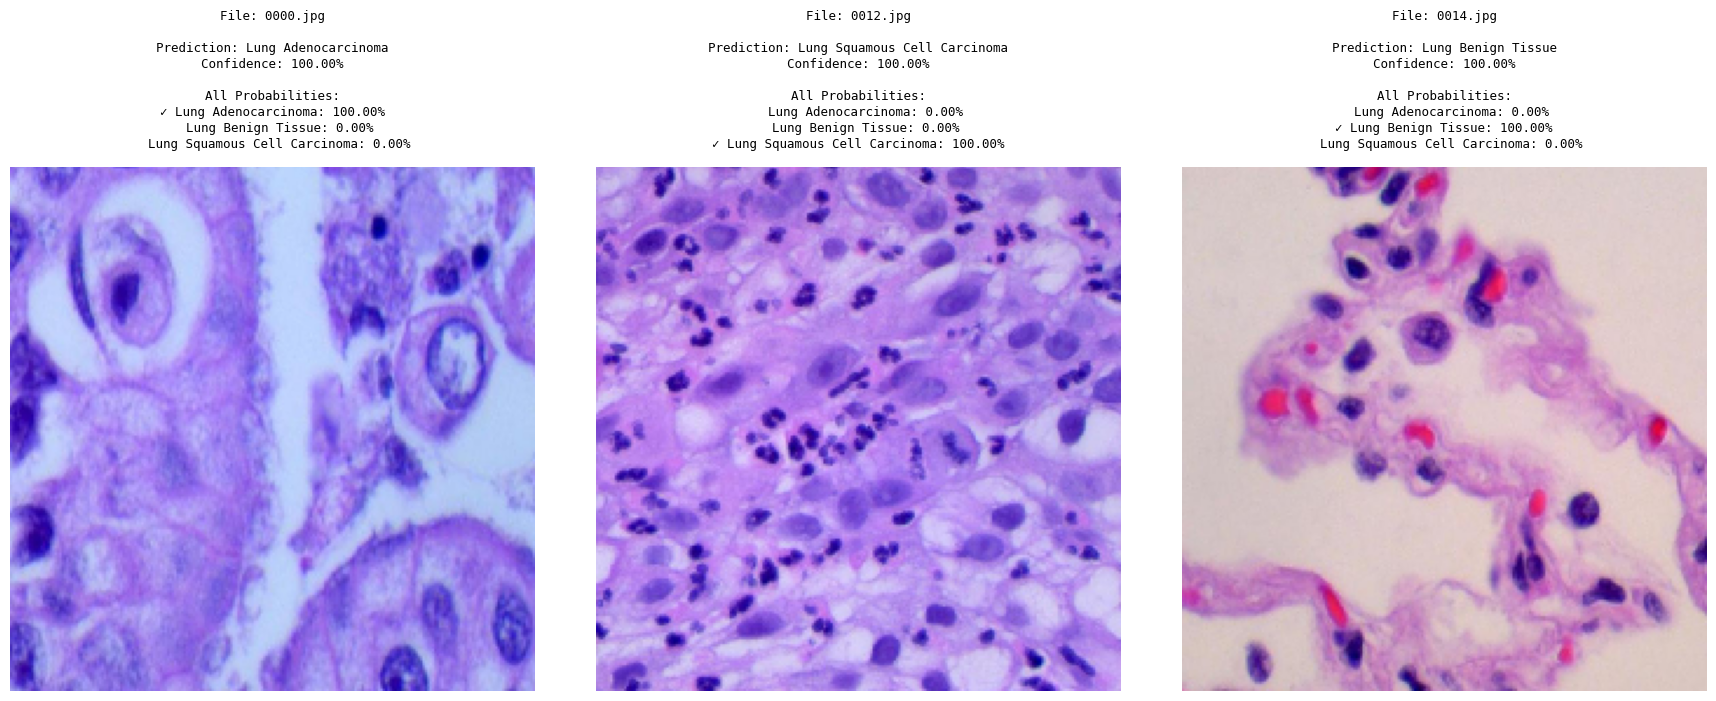

In [13]:
num_images = len(results)
cols = min(3, num_images)
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 7*rows))

if num_images == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]

    ax.imshow(result['image'])

    title = f"File: {result['filename']}\n\n"
    title += f"Prediction: {result['predicted_label']}\n"
    title += f"Confidence: {result['confidence']:.2%}\n\n"
    title += "All Probabilities:\n"

    for i, (class_name, prob) in enumerate(zip(CLASS_NAMES, result['predictions'])):
        label = CLASS_LABELS[class_name]

        if i == result['predicted_class_idx']:
            title += f"✓ {label}: {prob:.2%}\n"
        else:
            title += f"  {label}: {prob:.2%}\n"

    ax.set_title(title, fontsize=9, ha='center', va='top',
                 pad=15, family='monospace', linespacing=1.3)
    ax.axis('off')

for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout(pad=3.0)
plt.show()